In [278]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import pathlib
from tensorflow import keras

In [279]:
def train_val_generators(TRAINING_DIR, TESTING_DIR):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest'
                                      )
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=15,
                                                       class_mode='categorical',
                                                       target_size=(150,150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                  batch_size=15,
                                                                 class_mode='categorical',
                                                                 target_size=(150, 150))
    
    return train_generator, validation_generator

In [280]:
TRAINING_DIR = "../ROBOTSDATASET/training/"
TESTING_DIR = "../ROBOTSDATASET/testing/"
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 1919 images belonging to 12 classes.
Found 481 images belonging to 12 classes.


In [281]:
pre_trained_model = MobileNetV2(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights='imagenet'
                               )

In [282]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [283]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_20[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [284]:
last_layer = pre_trained_model.get_layer('block_15_add')
last_output = last_layer.output
last_output

<KerasTensor: shape=(None, 5, 5, 160) dtype=float32 (created by layer 'block_15_add')>

In [285]:
from tensorflow.keras import Model
x = tf.keras.layers.Flatten()(last_output)
x= tf.keras.layers.Dense(128, activation='relu')(x)
x= tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(12, activation='softmax')(x)

model_1 = Model(pre_trained_model.input, x)

model_1.summary()


Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_20[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']        

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [286]:
# Set the training parameters
model_1.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [287]:
# Train the model
history_1 = model_1.fit(train_generator, epochs=25, steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)

Epoch 1/25
15/15 [==============================] - 11s 532ms/step - loss: 8.7170 - accuracy: 0.1200 - val_loss: 2.6018 - val_accuracy: 0.1778
Epoch 2/25
15/15 [==============================] - 7s 496ms/step - loss: 2.4812 - accuracy: 0.2089 - val_loss: 2.6484 - val_accuracy: 0.2222
Epoch 3/25
15/15 [==============================] - 7s 466ms/step - loss: 2.3393 - accuracy: 0.2622 - val_loss: 2.3793 - val_accuracy: 0.2000
Epoch 4/25
15/15 [==============================] - 7s 458ms/step - loss: 2.2055 - accuracy: 0.2533 - val_loss: 1.7305 - val_accuracy: 0.4889
Epoch 5/25
15/15 [==============================] - 9s 573ms/step - loss: 2.2282 - accuracy: 0.2622 - val_loss: 2.3897 - val_accuracy: 0.2667
Epoch 6/25
15/15 [==============================] - 7s 436ms/step - loss: 2.0835 - accuracy: 0.3304 - val_loss: 1.6579 - val_accuracy: 0.4444
Epoch 7/25
15/15 [==============================] - 7s 436ms/step - loss: 1.9667 - accuracy: 0.3289 - val_loss: 2.0121 - val_accuracy: 0.3111
Epoch

In [288]:
#

In [289]:
import tensorflow as tf

model_2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

# Print the model summary
model_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_318 (Conv2D)         (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_319 (Conv2D)         (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_320 (Conv2D)         (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 17, 17, 128)    

In [290]:
# Set the training parameters
model_2.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [291]:
# Train the model
history_2 = model_2.fit(train_generator, epochs=25, steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)

Epoch 1/25
15/15 [==============================] - 14s 779ms/step - loss: 2.9030 - accuracy: 0.0844 - val_loss: 2.4819 - val_accuracy: 0.0889
Epoch 2/25
15/15 [==============================] - 12s 793ms/step - loss: 2.4940 - accuracy: 0.1156 - val_loss: 2.5079 - val_accuracy: 0.0222
Epoch 3/25
15/15 [==============================] - 12s 785ms/step - loss: 2.5015 - accuracy: 0.1378 - val_loss: 2.4996 - val_accuracy: 0.0667
Epoch 4/25
15/15 [==============================] - 12s 798ms/step - loss: 2.4837 - accuracy: 0.1156 - val_loss: 2.4802 - val_accuracy: 0.0889
Epoch 5/25
15/15 [==============================] - 12s 772ms/step - loss: 2.4914 - accuracy: 0.1200 - val_loss: 2.4634 - val_accuracy: 0.2222
Epoch 6/25
15/15 [==============================] - 12s 821ms/step - loss: 2.4784 - accuracy: 0.0978 - val_loss: 2.4477 - val_accuracy: 0.2000
Epoch 7/25
15/15 [==============================] - 13s 854ms/step - loss: 2.4633 - accuracy: 0.1467 - val_loss: 2.4096 - val_accuracy: 0.1556

In [292]:
from tensorflow.keras import Model
x = tf.keras.layers.Flatten()(last_output)
x= tf.keras.layers.Dense(128, activation='relu')(x)
x= tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(12, activation='softmax')(x)

model_3 = Model(pre_trained_model.input, x)

model_3.summary()


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_20[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']        

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [293]:
# Set the training parameters
model_3.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [294]:
# Train the model
history_3 = model_3.fit(train_generator, epochs=25, steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)

Epoch 1/25
15/15 [==============================] - 10s 493ms/step - loss: 9.4655 - accuracy: 0.1429 - val_loss: 3.7422 - val_accuracy: 0.2000
Epoch 2/25
15/15 [==============================] - 7s 448ms/step - loss: 2.8185 - accuracy: 0.3289 - val_loss: 1.9319 - val_accuracy: 0.4000
Epoch 3/25
15/15 [==============================] - 6s 369ms/step - loss: 2.4870 - accuracy: 0.2222 - val_loss: 2.1805 - val_accuracy: 0.2000
Epoch 4/25
15/15 [==============================] - 6s 404ms/step - loss: 2.1501 - accuracy: 0.3156 - val_loss: 1.9032 - val_accuracy: 0.2889
Epoch 5/25
15/15 [==============================] - 6s 406ms/step - loss: 1.9913 - accuracy: 0.3600 - val_loss: 2.1441 - val_accuracy: 0.2667
Epoch 6/25
15/15 [==============================] - 6s 394ms/step - loss: 1.9127 - accuracy: 0.3422 - val_loss: 1.6605 - val_accuracy: 0.4889
Epoch 7/25
15/15 [==============================] - 6s 415ms/step - loss: 1.9356 - accuracy: 0.3333 - val_loss: 1.7835 - val_accuracy: 0.4222
Epoch

In [295]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


# Set the weights file you downloaded into a variable
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model_inception = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model_inception.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model_inception.layers:
    layer.trainable = False

In [296]:
pre_trained_model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_322 (Conv2D)            (None, 74, 74, 32)   864         ['input_21[0][0]']               
                                                                                                  
 batch_normalization_282 (Batch  (None, 74, 74, 32)  96          ['conv2d_322[0][0]']             
 Normalization)                                                                                   
                                                                                       

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_292 (Batch  (None, 16, 16, 96)  288         ['conv2d_332[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_293 (Batch  (None, 16, 16, 32)  96          ['conv2d_333[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_287 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_287[0][0]']
                                                                                                  
 activatio

 activation_304 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_342 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_345 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_304[0][0]']         
                                                                                                  
 batch_normalization_302 (Batch  (None, 16, 16, 48)  144         ['conv2d_342[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_305 (Batch  (None, 16, 16, 96)  288         ['conv2d_345[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_308[0][0]',         
                                                                  'activation_311[0][0]',         
                                                                  'max_pooling2d_54[0][0]']       
                                                                                                  
 conv2d_356 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_316 (Batch  (None, 7, 7, 128)   384         ['conv2d_356[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_316 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_316[0][0]']
          

                                                                                                  
 batch_normalization_326 (Batch  (None, 7, 7, 160)   480         ['conv2d_366[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_326 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_326[0][0]']
                                                                                                  
 conv2d_367 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_326[0][0]']         
                                                                                                  
 batch_normalization_327 (Batch  (None, 7, 7, 160)   480         ['conv2d_367[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_377 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_336[0][0]']         
                                                                                                  
 batch_normalization_337 (Batch  (None, 7, 7, 160)   480         ['conv2d_377[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_337 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_337[0][0]']
                                                                                                  
 conv2d_373 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_37

                                                                                                  
 activation_347 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_347[0][0]']
                                                                                                  
 conv2d_383 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_388 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_347[0][0]']         
                                                                                                  
 batch_normalization_343 (Batch  (None, 7, 7, 192)   576         ['conv2d_383[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_396 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_355[0][0]']         
                                                                                                  
 batch_normalization_352 (Batch  (None, 7, 7, 192)   576         ['conv2d_392[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_356 (Batch  (None, 7, 7, 192)   576         ['conv2d_396[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_352 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_352[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_360 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_360[0][0]']
                                                                                                  
 activation_361 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_361[0][0]']
                                                                                                  
 activation_364 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_364[0][0]']
                                                                                                  
 activation_365 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_365[0][0]']
                                                                                                  
 batch_normalization_366 (Batch  (None, 3, 3, 192)   576         ['conv2d_406[0][0]']             
 Normaliza

                                                                                                  
 activation_374 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_374[0][0]']
                                                                                                  
 batch_normalization_375 (Batch  (None, 3, 3, 192)   576         ['conv2d_415[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_367 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_367[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_369[0][0]',         
                                                                  'activation_370[0][0]']         
          

In [297]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model_inception.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [298]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (12, activation='sigmoid')(x)           

# Append the dense network to the base model
model_4 = Model(pre_trained_model_inception.input, x) 

model_4.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_322 (Conv2D)            (None, 74, 74, 32)   864         ['input_21[0][0]']               
                                                                                                  
 batch_normalization_282 (Batch  (None, 74, 74, 32)  96          ['conv2d_322[0][0]']             
 Normalization)                                                                                   
                                                                                           

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_292 (Batch  (None, 16, 16, 96)  288         ['conv2d_332[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_293 (Batch  (None, 16, 16, 32)  96          ['conv2d_333[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_287 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_287[0][0]']
                                                                                                  
 activatio

 activation_304 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_342 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_345 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_304[0][0]']         
                                                                                                  
 batch_normalization_302 (Batch  (None, 16, 16, 48)  144         ['conv2d_342[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_305 (Batch  (None, 16, 16, 96)  288         ['conv2d_345[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_308[0][0]',         
                                                                  'activation_311[0][0]',         
                                                                  'max_pooling2d_54[0][0]']       
                                                                                                  
 conv2d_356 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_316 (Batch  (None, 7, 7, 128)   384         ['conv2d_356[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_316 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_316[0][0]']
          

                                                                                                  
 batch_normalization_326 (Batch  (None, 7, 7, 160)   480         ['conv2d_366[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_326 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_326[0][0]']
                                                                                                  
 conv2d_367 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_326[0][0]']         
                                                                                                  
 batch_normalization_327 (Batch  (None, 7, 7, 160)   480         ['conv2d_367[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_377 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_336[0][0]']         
                                                                                                  
 batch_normalization_337 (Batch  (None, 7, 7, 160)   480         ['conv2d_377[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_337 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_337[0][0]']
                                                                                                  
 conv2d_373 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_37

                                                                                                  
 activation_347 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_347[0][0]']
                                                                                                  
 conv2d_383 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_388 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_347[0][0]']         
                                                                                                  
 batch_normalization_343 (Batch  (None, 7, 7, 192)   576         ['conv2d_383[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

In [299]:
model_4.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [300]:
len(train_generator)

128

In [301]:
# Train the model.
history_4 = model_4.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 25,
            )

Epoch 1/25
128/128 [==============================] - 129s 976ms/step - loss: 1.5586 - accuracy: 0.4815 - val_loss: 0.8573 - val_accuracy: 0.6861
Epoch 2/25
128/128 [==============================] - 125s 972ms/step - loss: 1.0006 - accuracy: 0.6540 - val_loss: 0.8592 - val_accuracy: 0.6944
Epoch 3/25
128/128 [==============================] - 124s 970ms/step - loss: 0.8487 - accuracy: 0.7170 - val_loss: 0.7703 - val_accuracy: 0.7360
Epoch 4/25
128/128 [==============================] - 124s 965ms/step - loss: 0.7938 - accuracy: 0.7275 - val_loss: 0.7318 - val_accuracy: 0.7110
Epoch 5/25
128/128 [==============================] - 125s 973ms/step - loss: 0.7157 - accuracy: 0.7665 - val_loss: 0.7939 - val_accuracy: 0.7318
Epoch 6/25
128/128 [==============================] - 172s 1s/step - loss: 0.7075 - accuracy: 0.7681 - val_loss: 0.7850 - val_accuracy: 0.7464
Epoch 7/25
128/128 [==============================] - 163s 1s/step - loss: 0.6023 - accuracy: 0.7910 - val_loss: 0.7491 - val_a

In [303]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [307]:
# Set the weights file you downloaded into a variable
local_weights_file = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model_resnet = ResNet50(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model_resnet.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model_resnet.layers:
    layer.trainable = False

In [308]:
pre_trained_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [309]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model_resnet.get_layer('conv4_block5_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 10, 10, 1024)


In [310]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (12, activation='sigmoid')(x)           

# Append the dense network to the base model
model_5 = Model(pre_trained_model_resnet.input, x) 

model_5.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

In [312]:
model_5.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [314]:
# Train the model.
history_5 = model_5.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 25,
            )

Epoch 1/25
128/128 [==============================] - 356s 3s/step - loss: 9.8425 - accuracy: 0.0787 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 2/25
128/128 [==============================] - 335s 3s/step - loss: 2.5760 - accuracy: 0.0855 - val_loss: 3.1765 - val_accuracy: 0.0832
Epoch 3/25
128/128 [==============================] - 356s 3s/step - loss: 2.5486 - accuracy: 0.0896 - val_loss: 2.4849 - val_accuracy: 0.0852
Epoch 4/25
128/128 [==============================] - 339s 3s/step - loss: 2.5491 - accuracy: 0.0844 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 5/25
128/128 [==============================] - 309s 2s/step - loss: 2.5258 - accuracy: 0.0797 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 6/25
128/128 [==============================] - 301s 2s/step - loss: 2.5293 - accuracy: 0.0730 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 7/25
128/128 [==============================] - ETA: 0s - loss: 2.5050 - accuracy: 0.0776

KeyboardInterrupt: 

In [317]:
h_1 = history_1.history['accuracy'][-1]
h_2  = history_2.history['accuracy'][-1]
h_3 = history_3.history['accuracy'][-1]
h_4 = history_4.history['accuracy'][-1]

In [318]:
df = pd.DataFrame({'Model':['MobileNetV2', 'Sequential_13', 'MobileNetV2', 'InceptionV3'], 'Accuracy':[h_1,  h_2, h_3,  h_4 ]})

In [319]:
df.head()

,Model,Accuracy
0,MobileNetV2,0.573333
1,Sequential_13,0.217778
2,MobileNetV2,0.535714
3,InceptionV3,0.880667


In [320]:
pd.DataFrame.to_csv(df, "Experimental_robots_dataset.csv")

In [321]:
model_4.save('models/experimental/model_4_robots_balanced_12')

INFO:tensorflow:Assets written to: models/experimental/model_4_robots_balanced_12\assets


INFO:tensorflow:Assets written to: models/experimental/model_4_robots_balanced_12\assets


In [322]:
# Load in the SavedModel format
saved_model = tf.keras.models.load_model('models/experimental/model_4_robots_balanced_12')

birman


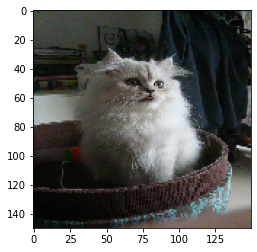

In [372]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = "../ROBOTSDATASET/testing/persian/Persian_153.jpg"

img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

print(list_of_class[np.argmax(model_4.predict(x))])

plt.imshow(img)



In [329]:
train_generator.class_indices

{'abyssinian': 0,
 'bengal': 1,
 'birman': 2,
 'bombay': 3,
 'british_shorthair': 4,
 'egyptian_mau': 5,
 'maine_coon': 6,
 'persian': 7,
 'ragdoll': 8,
 'russian_blue': 9,
 'siamese': 10,
 'sphynx': 11}

In [338]:
list_of_class = [key for  key,value in train_generator.class_indices.items()]
list_of_class

['abyssinian',
 'bengal',
 'birman',
 'bombay',
 'british_shorthair',
 'egyptian_mau',
 'maine_coon',
 'persian',
 'ragdoll',
 'russian_blue',
 'siamese',
 'sphynx']

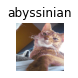

In [353]:
# import os
# def visualize_classification(imgpath):
#     img_path = f"../ROBOTSDATASET/testing/{imgpath}/"
#     for f in os.listdir(img_path):
#         file_path = img_path + f
#         img = image.load_img(file_path, target_size=(150, 150))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         plt.subplot(3,6,4)
# #         plt.title(f)
#         plt.axis('off')
#         plt.imshow(img)
#         plt.title(list_of_class[np.argmax(model_4.predict(x))])
        
# #     plt.show()
# visualize_classification('abyssinian')
        

    


In [ ]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
export_dir = 'model_1'
tf.saved_model.save(model, export_dir)

In [ ]:

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('model_1.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()



In [ ]:
import os

with open('labels.txt', 'w') as f:
    for label in os.listdir('../DATACATPEDIGREE/training/'):
        f.writelines(f'{label}\n')